In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import collections
import queue
import scipy.io as spio
from scipy.spatial import distance as dist
import random
import seaborn

class K_means:
    # num_centroids: número de centroids escolhido
    # dados: conjunto de dados que sera utilizado
    # num_iter: número de iterações que devemos submeter o conjunto de dados
    def __init__(self, num_centroids, dados, num_iter):
        self.num_centroids = num_centroids
        self.dados = dados
        self.num_iter = num_iter
        self.cluster_labels = []
        self.cluster_centroids = []
        self.predicted_cluster_labels = []
    
    def calc_distance(self, x, y):
        return dist.euclidean(x,y)

    def findClosestCentroids(self, ic, X):
        assigned_centroids = []
        for i in X:
            distance = []
            for j in ic:
                distance.append(self.calc_distance(i,j))
            assigned_centroids.append(np.argmin(distance))
        return assigned_centroids


    def calc_centroids(self, clusters, X):
        new_centroids = []
        new_df = pd.concat([pd.DataFrame(X), pd.DataFrame(clusters, columns=['cluster'])],
                        axis=1)
        for c in set(new_df['cluster']):
            current_cluster = new_df[new_df['cluster'] == c][new_df.columns[:-1]]
            cluster_mean = current_cluster.mean(axis=0)
            new_centroids.append(cluster_mean)
        return new_centroids
    
    def runKmeans(self):
        dataArray = np.array(self.dados)
        #print("Dataset em vetor")
       # print(dataArray)
        # Inicializa num_centroids índices de centroids escolhidos aleatoriamente
        init_centroids = random.sample(range(0, len(self.dados)), self.num_centroids)
       # print("Índices dos Centroids escolhidos")
       # print(init_centroids)
        # Recupera o valor de cada um dos índices de centroids escolhidos
        centroids = []
        for i in init_centroids:
            centroids.append(self.dados.loc[i])
        centroids = np.array(centroids)
        #print("Valores dos centroids escolhidos")
        #print(centroids)
        for i in range(self.num_iter):
            get_centroids = self.findClosestCentroids(centroids, dataArray)
            centroids = self.calc_centroids(get_centroids, dataArray)
            
            self.cluster_labels.append(get_centroids)
            self.cluster_centroids.append(centroids)
    ### TEM QUE MUDAR MANUALMENTE AS FUNÇÕES DE PLOT PARA NÚMERO DE CLUSTERS DIFERENTES
    def plotKmeans(self):
        dataArray = np.array(self.dados)
        for i in range(self.num_iter):
            ## DataFrame precisa ser criado manualmente de acordo com o dataset
            datatest = pd.DataFrame({'Column1': dataArray[:, 0], 'Column2': dataArray[:, 1], 'Column3': dataArray[:, 2], 'Column4': dataArray[:, 3], 'Cluster': self.cluster_labels[i]})
            groups = datatest.groupby("Cluster")

            #plt.scatter(dataArray[:, 0], dataArray[:, 2], alpha=0.1)
            #plt.show()

            plt.figure()
            for name, group in groups:
                plt.plot(group["Column1"], group["Column2"], marker="o", linestyle="", label=name, zorder=1) 
            plt.scatter(np.array(self.cluster_centroids[i])[:, 0], np.array(self.cluster_centroids[i])[:, 1], color=['black','green','red'], marker="*",zorder=2, s=100)
            
    ### TEM QUE MUDAR MANUALMENTE AS FUNÇÕES DE PLOT PARA NÚMERO DE CLUSTERS DIFERENTES
    def plotPredict(self, test_dataset):
        dataArray = np.array(test_dataset)
        ## DataFrame precisa ser criado manualmente de acordo com o dataset
        datatest = pd.DataFrame({'Column1': dataArray[:, 0], 'Column2': dataArray[:, 1], 'Column3': dataArray[:, 2], 'Column4': dataArray[:, 3], 'Cluster': self.predicted_cluster_labels})
        groups = datatest.groupby("Cluster")

        #plt.scatter(dataArray[:, 0], dataArray[:, 2], alpha=0.1)
        #plt.show()

        plt.figure()
        for name, group in groups:
            plt.plot(group["Column1"], group["Column2"], marker="o", linestyle="", label=name, zorder=1)
        plt.scatter(np.array(self.cluster_centroids[self.num_iter - 1])[:, 0], np.array(self.cluster_centroids[self.num_iter - 1])[:, 1], color=['black','green', 'red'], marker="*",zorder=2, s=100)
        
    def listaTodasDistanciaCentro(self):
        dataArray = np.array(self.dados)
        distancias = []
        
        for i in range(len(dataArray)):
            index = np.array(self.cluster_labels[self.num_iter - 1])[i]
            vetor = np.array(self.cluster_centroids[self.num_iter - 1])
            distancias.append(self.calc_distance(dataArray[i], vetor[index, :]))
        return distancias
    
    def predict(self, test_dataset):
        dataArray = np.array(test_dataset)
        centros_clusters = self.cluster_centroids[self.num_iter - 1]
        for i in dataArray:
            distancia_closest_cluster = 100000
            for j in range(0, len(centros_clusters)):
                distancia_cluster_atual = self.calc_distance(i, centros_clusters[j])
                #print(distancia_cluster_atual, distancia_closest_cluster, self.predicted_cluster_labels)
                if(distancia_cluster_atual < distancia_closest_cluster):
                    distancia_closest_cluster = distancia_cluster_atual
                    closest_cluster_index = j
                    #print("         {} {}".format(distancia_closest_cluster, closest_cluster_index))
            self.predicted_cluster_labels.append(closest_cluster_index)
        return self.predicted_cluster_labels
                    
            


# Elbow Method
def elbowKmeans(dataset, num_range_clusters, num_iter):
    custo_total = []
    for i in range(1,num_range_clusters + 1):
        kmeans = K_means(i, dataset, num_iter)
        kmeans.runKmeans()
        distancias = kmeans.listaTodasDistanciaCentro()
        custo = sum(distancias)/(2*len(dataset))
        custo = np.array(custo)
        custo = custo.item()
        custo_total.append(custo)

    x = np.arange(1, num_range_clusters + 1)
    plt.plot(x,custo_total)
    plt.title("Elbow curve")
    plt.xlabel("K -->")
    plt.ylabel("Dispersion")
     
def train_test_split(x, train_per = 0.9, test_per = 0.1,shuffle = True):
    
    n_samples = len(x)
    n_train, n_test = round(train_per*n_samples), round(test_per*n_samples)
    
    if shuffle:
        x_teste = x.reindex(np.random.permutation(x.index))
        train = x_teste.iloc[:n_train]
        test = x_teste.iloc[n_train:n_test+n_train]
    else:
        train = x.iloc[:n_train]
        test = x.iloc[n_train:n_test+n_train]
        
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)
        
    return train, test

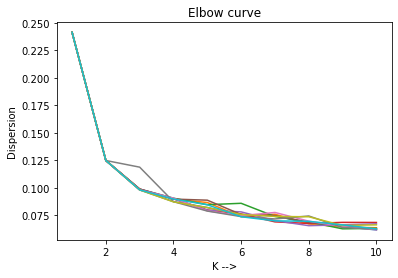

In [176]:
data_set = pd.read_csv('./iris.csv')
dataset = data_set.iloc[:, [0,1,2,3]].values
dataset = pd.DataFrame(dataset)


dataset[0] = pd.to_numeric(dataset[0])
dataset[1] = pd.to_numeric(dataset[1])
dataset[2] = pd.to_numeric(dataset[2])
dataset[3] = pd.to_numeric(dataset[3])

# Normaliza o dataset
def normalization(x, min_x, max_x):
    return (x - min_x) / (max_x - min_x) 
dataset[0] = dataset[0].apply(lambda x: normalization(x, min(dataset[0]), max(dataset[0])))
dataset[1] = dataset[1].apply(lambda x: normalization(x, min(dataset[1]), max(dataset[1])))
dataset[2] = dataset[2].apply(lambda x: normalization(x, min(dataset[2]), max(dataset[2])))
dataset[3] = dataset[3].apply(lambda x: normalization(x, min(dataset[3]), max(dataset[3])))



##Teste elbow
for i in range(10):
    elbowKmeans(dataset, 10, 20)
##Teste do predict()
#train, test = train_test_split(dataset)

#kmeans = K_means(3, train, 20)
#kmeans.runKmeans()
#kmeans.plotKmeans()
#predicted_clusters = kmeans.predict(test)
#kmeans.plotPredict(test)



Text(0, 0.5, 'Dispersion')

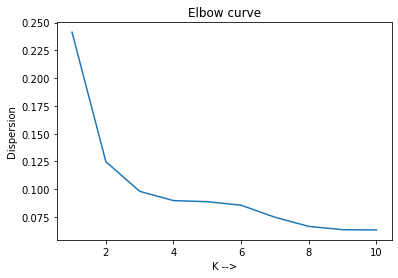

In [41]:
# Carrega o dataset
data_input = [i.strip().split() for i in open("./cluster.dat").readlines()]
data_input = pd.DataFrame(data_input)
data_input[0] = pd.to_numeric(data_input[0])
data_input[1] = pd.to_numeric(data_input[1])




# Normaliza o dataset
def normalization(x, min_x, max_x):
    return (x - min_x) / (max_x - min_x) 
data_input[0] = data_input[0].apply(lambda x: normalization(x, min(data_input[0]), max(data_input[0])))
data_input[1] = data_input[1].apply(lambda x: normalization(x, min(data_input[1]), max(data_input[1])))


# Instancia a classe do K-means
k_means = K_means(3, data_input, 50)
k_means.runKmeans()


[[0.36969697 0.98161765]
 [0.35       0.94117647]
 [0.33636364 0.97058824]
 ...
 [0.96666667 0.88419118]
 [0.98030303 0.88970588]
 [0.94090909 0.86948529]]


IndexError: index 2 is out of bounds for axis 1 with size 2